In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
plt.style.use('paper')

In [2]:
Mp = 1.e-8
def makesim(e=0.01, dtOverT = 0.01):
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=Mp, P=1., e=e)
    sim.move_to_com()
    sim.dt = dtOverT*sim.particles[1].P

    return sim

In [3]:
alpha = (7./40.)**0.5
beta = 1/48./alpha

def X(sim, kepler, damp, a, b, h):
    kepler.step(sim, -a*h)
    damp.step(sim, b*h)
    kepler.step(sim, a*h)
    return sim

def Z(sim, kepler, damp, a, b, h):
    sim = X(sim, kepler, damp, -a, -b, h)
    sim = X(sim, kepler, damp, a, b, h)
    return sim

def corrector3(sim, kepler, damp, h):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a2, b2, h)
    sim = Z(sim, kepler, damp, a1, b1, h)
    return sim 

def corrector3inv(sim, kepler, damp, h):
    a1 = -alpha
    a2 = alpha
    b2 = beta/2.
    b1 = -beta/2.
    
    sim = Z(sim, kepler, damp, a1, -b1, h)
    sim = Z(sim, kepler, damp, a2, -b2, h)
    return sim

def run(e=0.1, dt = 0.01, taua = 1000, tmax = 1000., corrector=0):
    simKD = makesim(e=e, dtOverT=dt)
    rebxKD = reboundx.Extras(simKD)
    modKD = rebxKD.load_force("modify_orbits_forces")
    psKD = simKD.particles
    psKD[1].params['tau_a'] = -taua

    simKD.integrator = "none"
    keplerKD = rebxKD.load_operator("kepler")
    integforceKD = rebxKD.load_operator("integrate_force")
    integforceKD.params['force'] = modKD
    integforceKD.params['integrator'] = reboundx.integrators["rk4"]

    rebxKD.add_operator(keplerKD, dtfraction=1., timing="post")
    rebxKD.add_operator(integforceKD, dtfraction=1., timing="post")

    sim = makesim(e=e, dtOverT=dt)
    sim.integrator = "ias15"
    rebx = reboundx.Extras(sim)
    mod = rebx.load_force("modify_orbits_forces")
    rebx.add_force(mod)

    ps = sim.particles
    ps[1].params['tau_a'] = -taua

    Nout = 1000
    Eerr = np.zeros(Nout)
    times = np.linspace(0,  tmax, Nout)
    for i, time in enumerate(times):
        if corrector == 1:
            keplerKD.step(simKD, simKD.dt/2.)
            simKD.integrate(time, exact_finish_time=0)
            keplerKD.step(simKD, -simKD.dt/2.)
        elif corrector == 3:
            simKD = corrector3(simKD, keplerKD, integforceKD, simKD.dt)
            keplerKD.step(simKD, simKD.dt/2.)
            simKD.integrate(time, exact_finish_time=0)
            keplerKD.step(simKD, -simKD.dt/2.)
            simKD = corrector3inv(simKD, keplerKD, integforceKD, simKD.dt)
        else:   
            simKD.integrate(time, exact_finish_time=0)
        sim.integrate(simKD.steps_done*simKD.dt)
        E = sim.calculate_energy()
        EKD = simKD.calculate_energy()
        Eerr[i] = np.abs((EKD-E)/E)
    return np.max(Eerr), sim.particles[1].P

In [4]:
%%time

e=0.1
taua = 100
tmax = taua # initial orbital periods, more since period will decrease
Nout = 100
dts = np.logspace(0, -4, Nout)
Eerrs, Eerrscorr1, Eerrscorr3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, dt in enumerate(dts):
    Eerrs[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt)
    Eerrscorr1[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt, corrector=1)
    Eerrscorr3[i], Pf = run(taua=taua, tmax=tmax, e=e, dt=dt, corrector=3)

/mnt/ssd/Dropbox/Dropbox (Princeton)/workspace/rebound/rebound/simulation.py:664: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 1min 51s, sys: 135 ms, total: 1min 51s
Wall time: 1min 51s


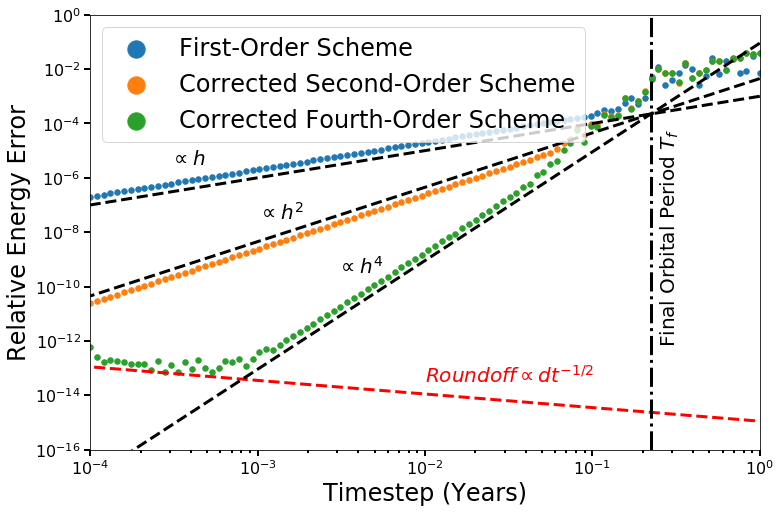

In [5]:
fig, ax = plt.subplots(figsize=(12,8))

mid = int(0.6*Nout)

s=30
ax.scatter(dts, Eerrs, s=s, label='First-Order Scheme')
ax.scatter(dts, Eerrscorr1, s=s, label='Corrected Second-Order Scheme')
ax.scatter(dts, Eerrscorr3, s=s, label='Corrected Fourth-Order Scheme')

ax.plot(np.logspace(-5, 0, 10), 2.**(-53)*(tmax/np.logspace(-5, 0, 10))**0.5, '--', c='r')
ax.plot(dts, Pf/taua *(dts/Pf)**2 * e, 'k--')
ax.plot(dts, Pf/taua *(dts/Pf) * e, 'k--')
ax.plot(dts, Pf/taua *(dts/Pf)**4 * e, 'k--')

ax.text(3.e-4, 3.e-6, r'$\propto h$', fontsize=20)
ax.text(1.e-3, 3.e-8, r'$\propto h^2$', fontsize=20)
ax.text(3.e-3, 3.e-10, r'$\propto h^4$', fontsize=20)
ax.text(1e-2, 3.e-14, r'$Roundoff \propto dt^{-1/2}$', color='red', fontsize=20)
ax.text(0.25, 1.e-12, r'Final Orbital Period $T_f$', fontsize=20, rotation=90)
ax.axvline(Pf, c='k', linestyle='-.')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1.e-16, 1.])
ax.set_xlim([1.e-4, 1.])
lgnd = ax.legend(fontsize=24,loc='upper left', scatterpoints=1)
for handle in lgnd.legendHandles:
    handle.set_sizes([300])

ax.set_ylabel('Relative Energy Error', fontsize=24)
ax.set_xlabel('Timestep (Years)', fontsize=24)

fig.savefig('fig4.pdf', bbox_inches='tight')